In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import scipy
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

from networkx.algorithms import bipartite

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './preprocessed_data'
IMG_PATH = './images'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_preprocessed.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_preprocessed.tsv')
SCORE_PATH = os.path.join(DATA_PATH, 'score_function.tsv')
CAREER_BOOSTER_PATH = os.path.join(IMG_PATH, './career_boosters')
CAREER_BOOSTER_IDs = os.path.join(CAREER_BOOSTER_PATH, 'career_boosters_ids.csv')

## 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars['min_year'].fillna(0, inplace=True)
df_chars['min_year_score'].fillna(0, inplace=True)
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,0.0,0.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,Ghosts of Mars,"Documentary, Culture & Society, Gay, Gay Interest",2001,2000.0,57.0


## 1.2 The data score

In [5]:
df_numbers=pd.read_csv(SCORE_PATH, sep='\t')
df_numbers.drop(['min_year', 'min_year_score'], axis=1, inplace=True)
df_numbers.head(2)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Jane Fonda,99.0,346.5,181.5,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,...,38.038043,36.229737,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250
1,Clint Eastwood,348.0,174.0,460.0,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,...,1551.673707,3219.994472,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952


# 2. Dataset preparation

#### Merge of the characters dataset with the score function

In [6]:
df_chars_merged = df_chars.merge(df_numbers, on='actor_name', how='left').copy()
numbers_columns = df_numbers.columns[1:]
df_chars_merged[numbers_columns] = df_chars_merged[numbers_columns].fillna(0)
df_chars_merged['min_year'] = df_chars_merged['min_year'].astype('int')
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,42.750000,34.200000,28.500000,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,1356.146032,2146.828571,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,645.500000,477.600000,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,764.333333,388.000000,261.583333,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333


In [7]:
nb_actors = df_chars_merged['actor_name'].nunique()
print("There are {} actors in this dataset.".format(nb_actors))

There are 34388 actors in this dataset.


#### Add two new columns:
* `is_revealed`: boolean which is true if the release year of the movie the actor is starring in correspond to the year the actor has appeared in the numbers' ranking for the first time
* `already_revealed`: boolean which is true if the release year of the movie the actor is starring in correspond to a greater year than your revelation year: the actor has already appeared in the numbers ranking before starring in this movie

In [8]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,...,2005,2006,2007,2008,2009,2010,2011,2012,is_revealed,already_revealed
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,Ghosts of Mars,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,Ghosts of Mars,...,28.500000,24.428571,21.375000,19.000000,17.100000,15.545455,14.250000,13.153846,0,1
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,Ghosts of Mars,...,3255.369913,1990.897222,2641.254319,2432.196392,1729.285333,1391.918606,1179.534513,1029.515124,0,1
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,Ghosts of Mars,...,715.333333,426.228571,311.050000,930.650794,546.942857,2009.549784,1152.650000,2576.304895,0,1
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,Ghosts of Mars,...,261.583333,197.888889,159.400000,133.575758,115.023810,101.038462,90.111111,81.333333,0,1


#### Group movies and creates two new features
* `has revelation`: 1 if one actor is revealed among the casting, 0 otherwise
* `has famous actors`: number of famous actors in the casting of the movie

In [9]:
df_movie_revelation = df_chars_merged.groupby(['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA']).agg({'is_revealed': 'sum', 'already_revealed':'sum'}).copy().reset_index()
df_movie_revelation['m_release_year'] = df_movie_revelation['m_release_date'].dt.year
df_movie_revelation.rename({'is_revealed' : 'has_revelation', 'already_revealed' : 'has_famous_actors'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
0,3217,1992-10-09,"Gross-out film, Gross out, Comedy, Romance Film",1,0,1992
1,3333,1915-01-01,"Business, Computers, Finance & Investing, Anti...",0,0,1915
2,3746,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",1,1,1982
3,3837,1974-02-07,"Action/Adventure, Action, Comedy, Action Thril...",0,0,1974
4,3947,1986-08-01,"Detective, Crime Thriller, Detective fiction, ...",0,1,1986


In [10]:
nb_movies = df_movie_revelation['wikipedia_m_ID'].nunique()
nb_movies_revelation = df_movie_revelation['has_revelation'].value_counts()[1]
print("There are {} movies with a revelation which represents {:.2f}% of the movies.".format(nb_movies_revelation, nb_movies_revelation*100/nb_movies))
#df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_revelation'] > 0)]

There are 1859 movies with a revelation which represents 7.48% of the movies.


In [11]:
nb_movies_with_famous_actor = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors']>0) & (df_movie_revelation['has_revelation']>0)].shape[0]
print("Among movies with a revelation, there are {} movies with at least one famous actor which represents {:.2f}% of the movies with revelation.".format(nb_movies_with_famous_actor, nb_movies_with_famous_actor*100/nb_movies_revelation))

Among movies with a revelation, there are 1490 movies with at least one famous actor which represents 80.15% of the movies with revelation.


#### Proportion of movies per movie genre, depending on if the movie has a revelation among its cast

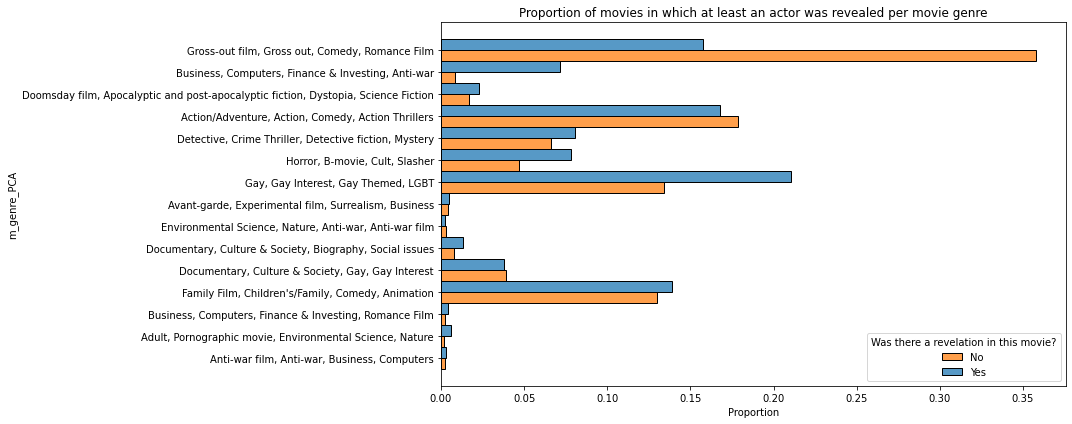

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
sns.histplot(data=df_movie_revelation, y='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.title("Proportion of movies in which at least an actor was revealed per movie genre")
plt.xlabel("Proportion")
plt.legend(title='Was there a revelation in this movie?', loc='lower right', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

For the movie with no famous actor, the revelation must come from another factor than co-acting.
Therefore, we decided to only focus on movies that had at least one actor, to analyse co-acting impact.

In [13]:
df_movie_revelation = df_movie_revelation.loc[(df_movie_revelation['has_famous_actors'] > 0)]
df_movie_revelation.head()

,wikipedia_m_ID,m_release_date,m_genre_PCA,has_revelation,has_famous_actors,m_release_year
2,3746,1982-06-25,"Doomsday film, Apocalyptic and post-apocalypti...",1,1,1982
4,3947,1986-08-01,"Detective, Crime Thriller, Detective fiction, ...",0,1,1986
6,4231,1992-07-31,"Horror, B-movie, Cult, Slasher",0,2,1992
7,4560,1995-05-18,"Gross-out film, Gross out, Comedy, Romance Film",0,1,1995
8,4726,1989-06-19,"Action/Adventure, Action, Comedy, Action Thril...",0,3,1989


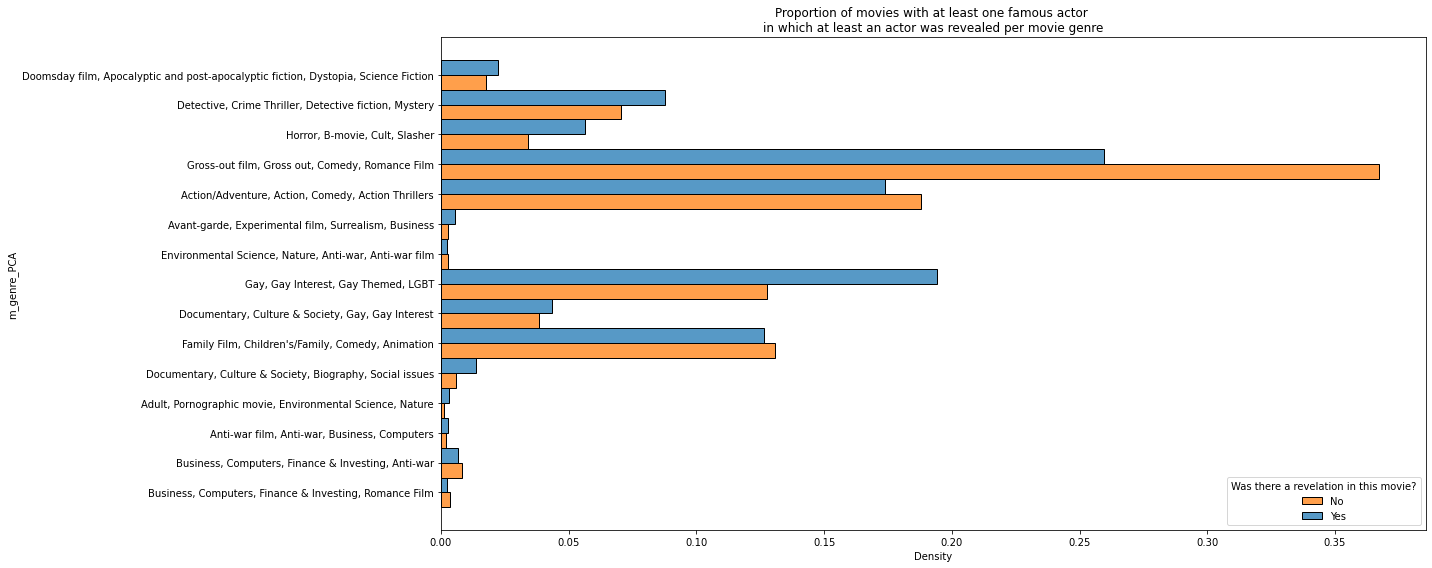

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
sns.histplot(data=df_movie_revelation, y='m_genre_PCA', hue='has_revelation', multiple="dodge", stat='density', common_norm=False)
plt.title("Proportion of movies with at least one famous actor \nin which at least an actor was revealed per movie genre")
plt.tight_layout()
plt.legend(title='Was there a revelation in this movie?', loc='lower right', labels=['No', 'Yes'])

plt.show()
image_format = 'svg'
OUTPUT_IMG_GENRE_HAS_REVELATION = os.path.join(CAREER_BOOSTER_PATH, 'movie_genre_has_a_revelation.svg')
fig.savefig(OUTPUT_IMG_GENRE_HAS_REVELATION, format=image_format, dpi=1200, transparent=False)

#### Number of movies with at least one famous actor and number of famous actors

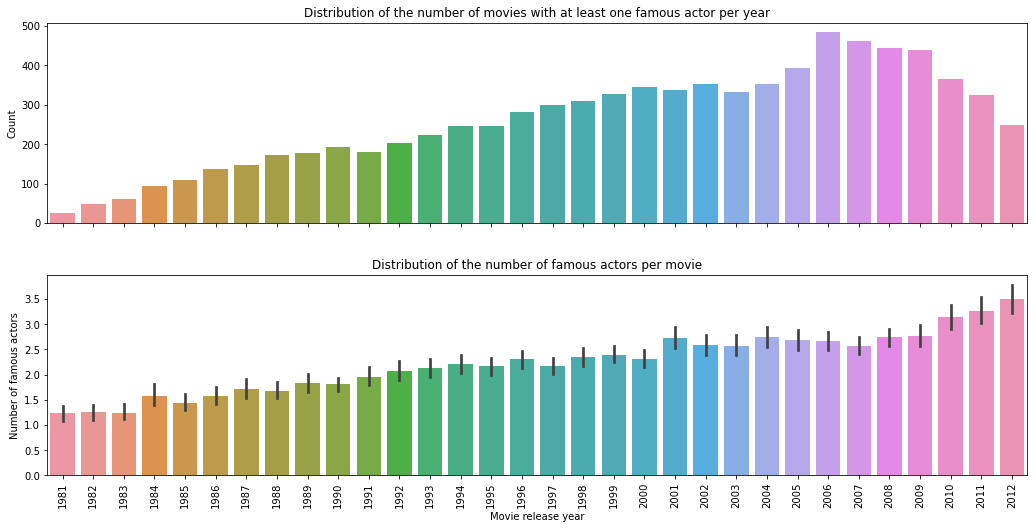

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
data_grouped = df_movie_revelation.groupby('m_release_year')['wikipedia_m_ID'].count().reset_index()
ax = axs[0]
sns.barplot(data=data_grouped,x='m_release_year', y='wikipedia_m_ID', ax=ax)
ax.set_title("Distribution of the number of movies with at least one famous actor per year")
ax.set_xlabel('')
ax.set_ylabel('Count')

ax = axs[1]
sns.barplot(data=df_movie_revelation,x='m_release_year', y='has_famous_actors', ax=ax)
ax.set_title("Distribution of the number of famous actors per movie")
plt.xticks(rotation = 90)
fig.tight_layout(pad=3.0)
ax.set_xlabel('Movie release year')
ax.set_ylabel('Number of famous actors')
plt.show()

As it can be seen, there is an increase in the number of movies per year but also a major increase in the number of famous actors per movie.
The second observation can be due to two facts:
* The global increase in the number of movies
* The scoring system: once you've been releaved, you stay famous. But the earlier we are, the less information we have about actors that were releaved before 1980 but for whom we don't have an accurate score.

For those two reasons, the time period will be split into 6 blocks, so that movies with comparable number of famous actors will be compared.

#### Revelation per pentade

In [16]:
nb_five_years_lower = range(1982, 2008,5)
nb_five_years_upper = range(1987, 2013, 5)

In [17]:
def define_popularity(min_year, lower_bound, upper_bound):
    """
    Compute the popularity of each actor between lower bound and upper bound period
    :param min_year: year of first appearance in the numbers dataset
    :param lower_bound: lower bound year
    :param upper_bound: upper bound year
    :return: the popularity, ie: famous (already revealed), revelation(being revealed) or unknown (not yet revealed)
    """
    if not min_year or min_year >= upper_bound:
        return 'unknown'
    if min_year < lower_bound:
        return 'famous'
    else:
        return 'revelation'

In [18]:
df_chars_revelation = df_movie_revelation.merge(df_chars_merged, on=['wikipedia_m_ID', 'm_release_date', 'm_genre_PCA'], how='inner').copy()
df_revelations_five_years = dict()
for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
    filter_conditions = (
        (df_chars_revelation['m_release_date'].dt.year >= y_lower) & 
        (df_chars_revelation['m_release_date'].dt.year < y_upper)
    )
    columns = ['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA','actor_name', 'actor_dob', 'is_revealed', 'already_revealed', 'min_year']
    df_filtered = df_chars_revelation.loc[filter_conditions, columns].copy()
    df_filtered['popularity'] = df_filtered['min_year'].apply(lambda x: define_popularity(x, y_lower, y_upper))
    df_revelations_five_years.update({range(y_lower, y_upper): df_filtered.copy()})

# 3. Carreer booster retrieval

In [19]:
def get_attributes(df_, graph_, previous_score):
    """
    Find attributes of the actors, attributes are ['actor_name', 'actor_dob', 'min_year', 'popularity']
    :param df_: original df with on which to merge.
    :param graph_: second dataframe that used to merge.
    :param previous_score: score the actor had the previous year
    :return: revelation: dictionnary of revelated actors
             famous: dictionnary of famous actors
             attrs_: attirbutes of revelations and famous
    """
    df_revelation = df_.merge(graph_.drop_duplicates('actor_name_x', keep='first'), left_on='actor_name', right_on='actor_name_x', how='inner')[['actor_name','actor_dob', 'min_year', 'popularity']]
    revelation = df_revelation.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    df_famous = df_.merge(graph_.drop_duplicates('actor_name_y', keep='first'), left_on='actor_name', right_on='actor_name_y', how='inner')[['actor_name','actor_dob', 'min_year', 'popularity' , '{}'.format(previous_score)]]
    famous = df_famous.drop_duplicates(keep='first').set_index('actor_name').to_dict('index')
    
    attrs_ = dict()
    attrs_.update(revelation)
    attrs_.update(famous)
    
    return revelation, famous, attrs_

In [20]:
def create_bipartite_graph(revelation, famous, attrs_, graph_):
    """
    Creates a bipartite graph with left nodes: revelation actors and right nodes: famous actors
    :param revelation: dictionnary of revelated actors
    :param famous: dictionnary of famous actors
    :param attrs_: attirbutes of revelations and famous
    :param graph_: df with actors pairs related by a movie that will be considered edges
    :return: bipartite_graph: bipartite graph
    """
    B = nx.Graph()
    B.add_nodes_from(revelation, bipartite=0)
    B.add_nodes_from(famous, bipartite=1)
    B.add_weighted_edges_from([(row['actor_name_x'], row['actor_name_y'], 1) for idx, row in graph_.iterrows()], weight='weight')

    colors = []
    for node in B:
        val = attrs_[node]['popularity']
        if val =='revelation':
            colors.append("green")
        elif val =='famous':
            colors.append("red")
        else:
            colors.append("gray")
    
    pos = {node:[0, i] for i,node in enumerate(revelation.keys())}
    pos.update({node:[1, i] for i,node in enumerate(famous.keys())})
    
    bipartite_graph = {'graph': B, 'pos': pos, 'node_color':colors}
    
    return bipartite_graph

In [21]:
def extract_partition_nodes(G: nx.Graph, attrs_, partition: str):
    """
    Extract the nodes from each side of the bipartite graph
    :param G: bipartite graph
    :param attrs_: attributes of the nodes
    :param partition: side of the bipartite graph
    :return: nodes of the side of the bipartite graph
    """
    nodeset = [x for x in G.nodes if attrs_[x]['popularity'] == partition]
    if partition != "revelation" and partition!="famous":
        raise Exception(f"No nodes exist in the partition {partition}!")
    return nodeset

In [22]:
def retrieve_career_boosters(graph_, previous_score, attrs_):
    """
    Find the actors that were famous in a film whith a revelation
    :param graph_: df with actors pairs related by a movie that will be considered edges
    :param previous_score: score the actor had the previous year
    :param attrs_: attirbutes of revelations and famous
    :return: bipartite_graph: bipartie graph
    """
    revelations_ = extract_partition_nodes(graph_,attrs_, "revelation")
    famous_ = extract_partition_nodes(graph_, attrs_, "famous")
    
    sources = revelations_
    targets = revelations_
    measures = dict()
    measures=['betweenness_centrality_subset', 'degree_centrality']
    
    bc_subset = nx.betweenness_centrality_subset(graph_, sources=sources, targets=targets)
    cc_subset = nx.degree_centrality(graph_)
    
    sorted_bc = sorted(bc_subset.items(), key=lambda kv: kv[1], reverse=True)
    sorted_cc = sorted(cc_subset.items(), key=lambda kv: kv[1], reverse=True)
    career_boosters_bc = []
    career_boosters_cc = []
    for (x, m) in sorted_bc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            dob = attrs_[x]['actor_dob']
            bc_measure = m
            cc_measure = cc_subset[x]
            famous_actor = {'actor_name':x,'actor_dob':dob, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_bc.append(famous_actor)
    for (x, m) in sorted_cc:
        if attrs_[x]['popularity']=='famous':
            score = attrs_[x]['{}'.format(previous_score)]
            min_year = attrs_[x]['min_year']
            dob = attrs_[x]['actor_dob']
            bc_measure = bc_subset[x]
            cc_measure = m
            famous_actor = {'actor_name':x,'actor_dob':dob, 'score_in_{}'.format(previous_score):score, 'revealed_in':min_year, 'betweenness_centrality_subset':bc_measure, 'degree_centrality':cc_measure}
            career_boosters_cc.append(famous_actor)
    
    return career_boosters_bc, career_boosters_cc

In [23]:
def compute_career_boosters_infos(df_, graph_, range_y, m_genre):
    """
    Compute the carreer booster infos that will be considered as attributes of each actor
    :param df_: df that helps retrieve the information of each actor
    :param graph_: df with actors pairs related by a movie that will be considered edges
    :param range_y: year before the pentade (to retrieve the score of famous actors at that time)
    :param m_genre: movie genre
    :return: df with all infos of the top 5 actors with highest centrality (either betweeeness centrality or degree centrality)
    """
    career_booster_infos = dict()
    for i, x in enumerate(df_[:5], start=1):
        key = x['actor_name']
        score = x['score_in_{}'.format(range_y.start-1)]
        min_year = x['revealed_in']
        dob = x['actor_dob']
        ranking = i
        bc_measure = x['betweenness_centrality_subset']
        dc_measure = x['degree_centrality']
        casting = graph_[graph_['actor_name_y'] == key]
        nb_actors_boosted_at_revelation = casting[casting['is_revealed_x'] == 1].shape[0]
        nb_actors_boosted_before_revelation = casting[casting['is_revealed_x'] == 0].shape[0]
        nb_actors_boosted = casting.shape[0]
        tmp_booster = {'booster_in': range_y,
                       'm_genre': m_genre,
                       'dob': dob,
                       'ranking': i,
                       'betweenness_centrality_subset': round(bc_measure, 0),
                       'degree_centrality': round(dc_measure, 3),
                       'actor_score_before_period': round(score, 2),
                       'nb_actors_boosted': nb_actors_boosted,
                       'nb_actors_boosted_at_revelation': nb_actors_boosted_at_revelation,
                       'nb_actors_boosted_before_revelation': nb_actors_boosted_before_revelation
        }
        career_booster_infos.update({key: tmp_booster})
    career_boosters_info_df = pd.DataFrame.from_dict(career_booster_infos, orient='index')
    return career_boosters_info_df

In [24]:
def carreer_booster_retrieval_for_all_genres():
    """
    Find the carreer boosters for all years and all genres
    :returns:
            - booster_bc: actors with highest betweenness centrality subset measure (per pentade per genre)
            - booster_dc: actors with highest degree centrality measure (per pentade per genre)
            - graphs: graphs corresponding to each pentade and each genre
    """
    graphs = dict()
    famous_ranking_bc = dict()
    famous_ranking_dc = dict()
    booster_bc = dict()
    booster_dc = dict()

    for y_lower, y_upper in zip(nb_five_years_lower, nb_five_years_upper):
        tmp_range = range(y_lower, y_upper)
        df_tmp = df_revelations_five_years[tmp_range].copy()
        df_tmp = df_tmp.merge(df_numbers[['actor_name', '{}'.format(y_lower-1)]], on='actor_name', how='left')
        df_tmp['{}'.format(y_lower-1)] = df_tmp['{}'.format(y_lower-1)].fillna(0)

        graph = pd.merge(df_tmp, df_tmp, on=['wikipedia_m_ID', 'm_name', 'm_release_date', 'm_genre_PCA'])
        filter_conditions = (
            (graph.popularity_x == 'revelation') & 
            (graph.popularity_y == 'famous') &
            (graph.m_release_date.dt.year <= graph.min_year_x)
        )
        graph = graph.loc[filter_conditions]
        
        unique_genres = df_tmp['m_genre_PCA'].unique()
        genre_iteration = ['all'] + list(unique_genres)
        
        graphs_genre = dict()
        famous_ranking_bc_genre = dict()
        famous_ranking_dc_genre = dict()
        booster_bc_genre = dict()
        booster_dc_genre = dict()
        
        for genre in genre_iteration:
            graph_genre = graph.copy()
            df_genre = df_tmp.copy()
            #print(genre)
            if genre !='all':
                #print("there")
                filter_conditions = (
                    (graph_genre.m_genre_PCA == genre)
                )
                graph_genre = graph.loc[filter_conditions]
                filter_conditions = (
                    (df_genre.m_genre_PCA == genre)
                )
                df_genre = df_genre.loc[filter_conditions]
            revelation_attributes, famous_attributes, attrs = get_attributes(df_genre, graph_genre, y_lower-1)

            tmp_graph = create_bipartite_graph(revelation_attributes, famous_attributes, attrs, graph_genre)
            graphs_genre.update({genre: tmp_graph})

            tmp_famous_ranking_bc, tmp_famous_ranking_dc = retrieve_career_boosters(tmp_graph['graph'], y_lower-1, attrs)
            famous_ranking_bc_genre.update({genre: tmp_famous_ranking_bc})
            famous_ranking_dc_genre.update({genre: tmp_famous_ranking_dc})
            
            tmp_career_booster_bc = compute_career_boosters_infos(tmp_famous_ranking_bc[:5], graph_genre, tmp_range, genre)
            booster_bc_genre.update({genre: tmp_career_booster_bc})

            tmp_career_booster_dc = compute_career_boosters_infos(tmp_famous_ranking_dc[:5], graph_genre, tmp_range, genre)
            booster_dc_genre.update({genre: tmp_career_booster_dc})
            
        graphs.update({tmp_range: graphs_genre})
        famous_ranking_bc.update({tmp_range: famous_ranking_bc_genre})
        famous_ranking_dc.update({tmp_range: famous_ranking_dc_genre})
        booster_bc.update({tmp_range: booster_bc_genre})
        booster_dc.update({tmp_range: booster_dc_genre})
        
    return booster_bc, booster_dc, graphs


To determine whether a famous actor is a carreer booster, it was decided to see how "central" the famous actor is.
Two measures were tested to compute the centrality of the famous actors:
* **degree centrality**: i.e highest number of revelation actors
* **betweenness centrality subset**: i.e how central the famous actors are. The subset measure was computed using only revelation actors as start and end targets as there was no interest in knowing which famous actor is central among other famous actors.
To do so, a bipartite graph between revelation and famous actors was of huge help as there were only edges between revelation and famous actors and no edge among each subset. 

It was chosen to focus on degree centrality as it shows who were the actors that were the linked to the most number of revelation actors.

In [25]:
career_booster_bc = dict()
career_booster_dc = dict()

#retrieve the carrier boosters
career_booster_bc, career_booster_dc, graph = carreer_booster_retrieval_for_all_genres()

# 4. Create the plots for every pentade and PCA genre

In [26]:
with open(CAREER_BOOSTER_IDs, 'w') as f:
    writer = csv.writer(f)
    for key_year, val_year in career_booster_dc.items():
        for key_genre, val_genre in val_year.items():
            name_genre = key_genre.replace(' ', '_')
            name_genre = ''.join(item for item in name_genre if (item.isalnum() or item=='_'))
            row = [key_year.start, key_year.stop-1, name_genre]
            writer.writerow(row)

In [27]:
for key_year, val_year in career_booster_dc.items():
    for key_genre, val_genre in val_year.items():
        name_genre = key_genre.replace(' ', '_')
        name_genre = ''.join(item for item in name_genre if (item.isalnum() or item=='_'))
        name_pkl = "career_booster_dc_{}_{}_genre_{}.pkl".format(key_year.start, key_year.stop-1, name_genre)
        
        OUTPUT_PKL = os.path.join(CAREER_BOOSTER_PATH, name_pkl)
        val_genre.to_pickle(OUTPUT_PKL)

# 5. Plot the bipartite graphs

In [28]:
genre = "Action/Adventure, Action, Comedy, Action Thrillers"

In [29]:
def show_labels_plt():
    """
    Trick to plot a legend in the bipartite graph
    :return:
    """
    plt.scatter([],[], c=['red'], label='Famous actors')
    plt.scatter([],[], c=['green'], label='Revelations')

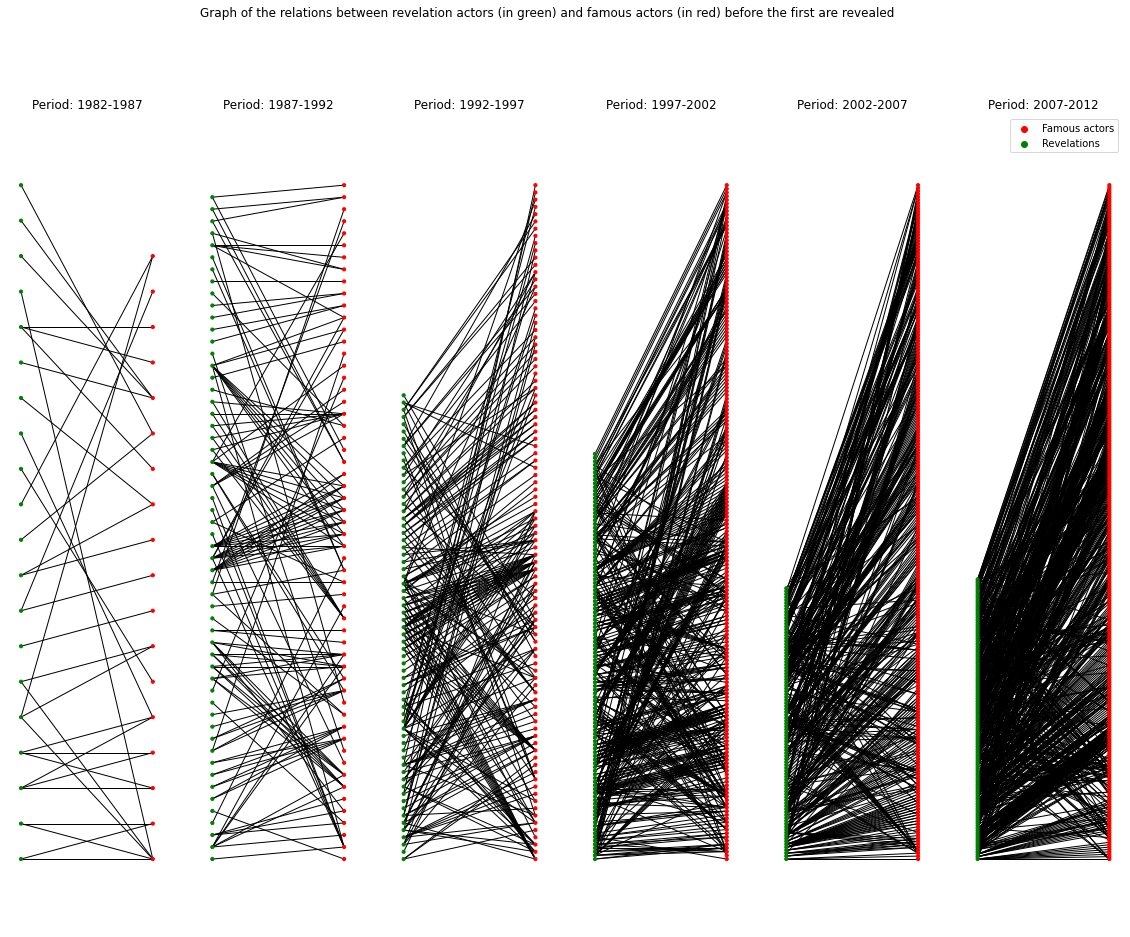

In [30]:
fig, axs = plt.subplots(1, 6, figsize=(20, 15))
for i, year in enumerate(graph):
    G = graph[year][genre]['graph']
    pos = graph[year][genre]['pos']
    node_color = graph[year][genre]['node_color']
    nx.draw(G, pos=pos, node_color=node_color, with_labels=False, node_size=10, ax=axs[i])
    axs[i].set_title("Period: {}-{}".format(year.start, year.stop))
    
fig.suptitle('Graph of the relations between revelation actors (in green) and famous actors (in red) before the first are revealed')

show_labels_plt()

plt.legend()
plt.show()

fig.tight_layout()

# 6. All genre kinds: who are the career boosters?

In [31]:
for k_year, v_year in career_booster_dc.items():
    print("\nRESULTS FOR PERIOD on ALL GENRES: {}-{}".format(k_year.start, k_year.stop))
    print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format('rank', 'name', 'score', 'nb_actors_boosted', 'nb_actors_boosted_at_revelation', 'nb_actors_boosted_before_revelation'))
    #print(v_year['all'].items())
    for i, row in v_year['all'].reset_index().iterrows():
        ranking = row['ranking']
        k_actor = row['index']
        actor_score_before_period = row['actor_score_before_period']
        nb_actors_boosted = row['nb_actors_boosted']
        nb_actors_boosted_at_revelation = row['nb_actors_boosted_at_revelation']
        nb_actors_boosted_before_revelation = row['nb_actors_boosted_before_revelation']
        print ("{:<5}: {:<18} {:<6} {:<17} {:<32} {:<5}".format(ranking, k_actor, round(actor_score_before_period), nb_actors_boosted, nb_actors_boosted_at_revelation, nb_actors_boosted_before_revelation))


RESULTS FOR PERIOD on ALL GENRES: 1982-1987
rank : name               score  nb_actors_boosted nb_actors_boosted_at_revelation  nb_actors_boosted_before_revelation
1    : Dennis Quaid       250    13                12                               1    
2    : Chevy Chase        885    13                8                                5    
3    : Dan Aykroyd        198    9                 4                                5    
4    : William Hurt       240    9                 7                                2    
5    : Kurt Russell       142    8                 4                                4    

RESULTS FOR PERIOD on ALL GENRES: 1987-1992
rank : name               score  nb_actors_boosted nb_actors_boosted_at_revelation  nb_actors_boosted_before_revelation
1    : John Candy         698    14                12                               2    
2    : Rick Moranis       152    13                10                               3    
3    : Charlie Sheen      490    9      